In [1]:
# Let's explore our mlp from last time a little deeper
#   - specifically, looking at the gradients that flow through the model
#   - how can we improve the way we train the network? answer: weight initialization
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_device("mps")

In [2]:
# read in all the words
words = open('res/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator(device='mps').manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

def step(epoch=0):
  global h
  global hpreact

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if epoch < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if epoch % 10000 == 0: # print every once in a while
    print(f'{epoch:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

In [7]:
# we notice that the network starts off with a very high loss.
step()  # view initial loss

      0/ 200000: 30.6079


In [8]:
# this tells us that our initialization could be better.
#   - to minimize the initial loss, we'd like the initial logits to be closer.
#     to zero and closer to a uniform distribution.
#   - we can scale the initial parameters to get "nicer" values that minimize the initial loss.
#     - biases can be scaled to 0.
#     - weights can be scaled by an arbitrary scale < 1.
#       - we shouldn't scale the weights to 0.
#       - we need to keep some entropy (randomness) in the weights so that we break symetry.
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

step()  # initial loss is much better now

11897
      0/ 200000: 3.3391


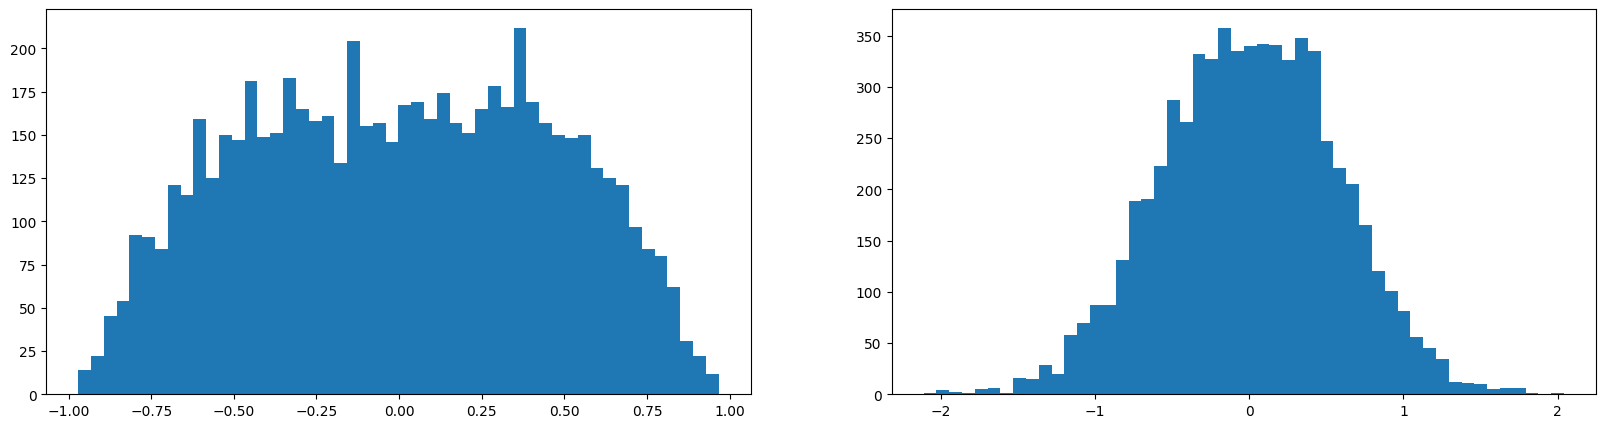

In [27]:
# let's take a look at the activations of the hidden layer.
# we notice that the tanh function is "saturating" (taking a value either -1.0 or 1.0) given its inputs.
#   - this can hinder learning a.k.a. vanishing gradient problem.
#     - neurons can "die" if their gradients all saturate to one value (i.e. -1 or 1 for tanh, 0 for relu, etc.).
#     - a neuron is said to be "dead" when it can't learn, given any input from the dataset.
#   - clearly, our pre-activations are taking extreme values, so we need to fix this.
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(h.view(-1).detach().cpu(), bins=50)  # view activations from hidden layer
plt.subplot(122)
plt.hist(hpreact.view(-1).detach().cpu(), bins=50)  # view pre-activations from hidden layer
plt.show()

In [104]:
# let's "fix" our initial hidden layer activations.
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

step()  # initial loss is much better now

11897
      0/ 200000: 3.2842


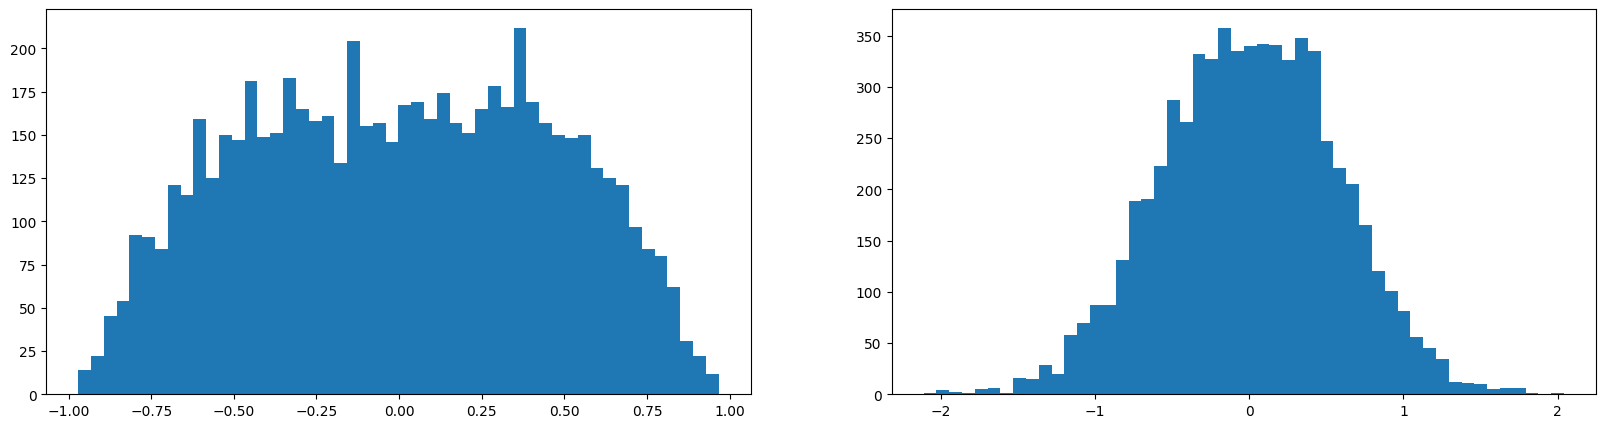

In [105]:
# hidden activations look good now
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(h.view(-1).detach().cpu(), bins=50)  # view activations from hidden layer
plt.subplot(122)
plt.hist(hpreact.view(-1).detach().cpu(), bins=50)  # view pre-activations from hidden layer
plt.show()

mean: 0.004041876178234816 std: 1.0046114921569824
mean: 0.0012269520666450262 std: 3.224067211151123
Δstd: 2.2194557189941406


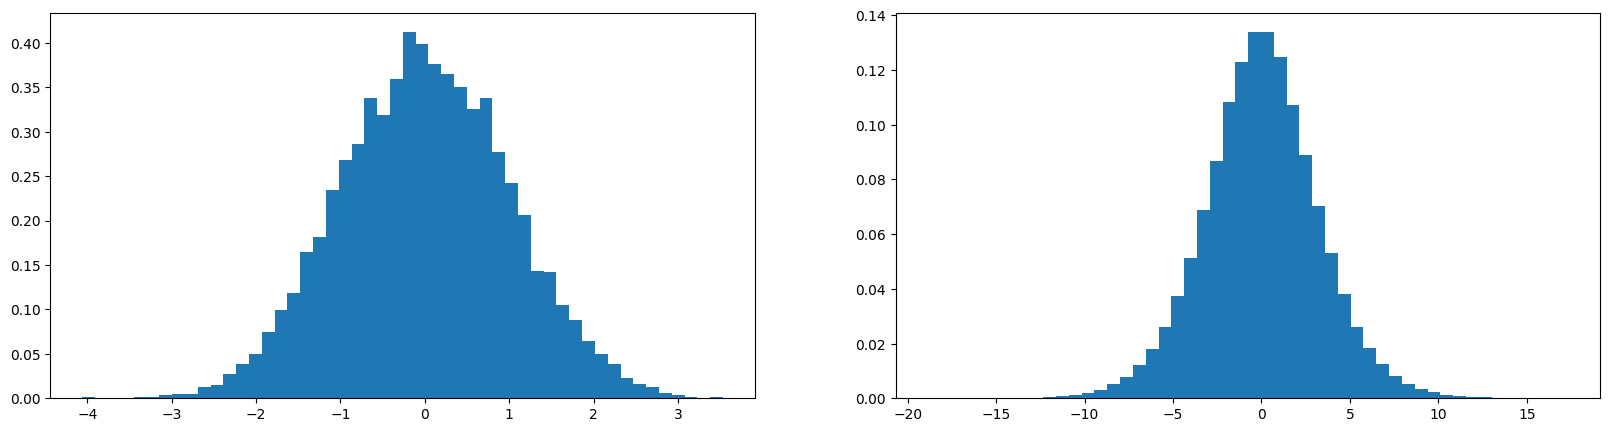

In [103]:
# so far our parameter scaling has been pretty arbitrary
#   - i.e. choosing random values like 0.01 and 0.1.
# there are more principled ways of initializing our parameters so that we get good results during training.
#   - if we play around with different weight scales for a single layer, we see that our input has a certain
#     gaussian distribution and that when we pass it through the layer this distribution is scaled (std changes).
#   - to get a good weight initialization, we'd like to choose a weight scale that makes the distribution of
#     the output roughly equal to the distribution of the input.
#   - why is this good? because we want the network to learn the underlying pattern in the input data, not how
#     to undo random shifts and scalings of the data because of how the network is defined.
W_scale = 1  # not great (delta ~= +2)
# W_scale = 5  # bad (delta ~= +15)
# W_scale = 0.001  # bad (delta ~= -0.995)
# W_scale = 1 / 10**0.5  # good (delta ~= +0.014)

x = torch.randn(1000, 10)
W = torch.randn(10, 200) * W_scale
y = x @ W
print("mean:", x.mean().item(), "std:", x.std().item())
print("mean:", y.mean().item(), "std:", y.std().item())
print("Δstd:", y.std().item() - x.std().item())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

In [115]:
# There are many other ways to initialize our parameters!

# for the following examples:
#   - `U` is a uniform distribution
#   - `N` is a normal (gaussian) distribution
#   - `fan_in` is the count of input features
#   - `fan_out` is the count of output features
#   - `gain` is a constant that depends on the type of nonlinearity we are working with and appropriately scales
#      the probability distribution of the output through the nonlinearity such that it matches the distribution
#      of the input (more info: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain).

# examples of other initialization strategies:
#   - pytorch initializes parameters with values in the range `U(−k, k)`, where `k = sqrt(1 / fan_in)`.
#   - "xavier initialization" is described in "Understanding the difficulty of training deep feedforward neural networks"
#     - in pytorch, it's implemented as torch::nn::init::xavier_uniform_ and  torch::nn::init::xavier_normal_
#     - uniform xavier: `U(-k, k)`, where `k = gain * sqrt(6 / (fan_in + fan_out))`
#     - normal xavier: `N(0, std^2)`, where `std = gain * sqrt(2 / (fan_in + fan_out))`
#   - "kaiming initialization" is described in "Delving Deep into Rectifiers"
#     - in pytorch, it's implemented as torch::nn::init::kaiming_uniform_ and torch::nn::init::kaiming_normal_
#     - uniform kaiming: `U(-k, k)`, where `k = gain * sqrt(3 / fan_in)``
#     - normal kaiming: `N(0, std^2)`, where `std = gain * sqrt(1 / fan_in)

# we can implement the various types of initialization we discussed above.
# now, we avoid having to use arbitrary values while still getting a reasonable initialization.

tanh_gain = 5 / 3
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * tanh_gain / (n_embd * block_size)**0.5  # kaiming_normal
b1 = torch.rand(n_hidden,                         generator=g) / n_hidden**0.5  # pytorch uniform init
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * (2 / (n_hidden + vocab_size))**0.5  # xavier_normal
b2 = torch.rand(vocab_size,                       generator=g) / vocab_size**0.5  # pytorch uniform init

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

step()  # initial loss is much better now

11897
      0/ 200000: 3.9386


In [116]:
# let's fully train the network with our new weight initialization
max_steps = 200000
batch_size = 32
lossi = []

def step(epoch=0):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if epoch < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if epoch % 10000 == 0: # print every once in a while
    print(f'{epoch:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

for epoch in range(max_steps):
    step(epoch)

      0/ 200000: 3.3687
  10000/ 200000: 2.4263
  20000/ 200000: 1.8829
  30000/ 200000: 2.3739
  40000/ 200000: 1.9959
  50000/ 200000: 2.6068
  60000/ 200000: 2.2509
  70000/ 200000: 2.1183
  80000/ 200000: 2.0860
  90000/ 200000: 1.7825
 100000/ 200000: 2.0837
 110000/ 200000: 1.6492
 120000/ 200000: 1.6562
 130000/ 200000: 1.6278
 140000/ 200000: 2.1015
 150000/ 200000: 2.1038
 160000/ 200000: 1.6219
 170000/ 200000: 2.0074
 180000/ 200000: 2.0858
 190000/ 200000: 1.8780


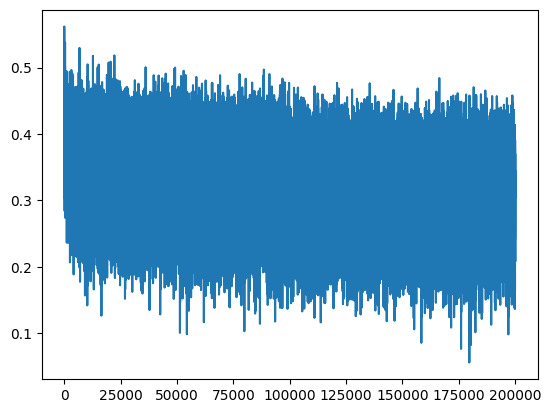

In [117]:
# plot the loss over time
plt.plot(lossi)

In [119]:
# evaluate train loss and validation loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

# awesome! our validation loss before was 2.2065, and now it's 2.1053.
# just by changing how we initialize our parameters, the model is performing better.

train 2.040064573287964
val 2.1053202152252197
